# Results

In [50]:
import re
import ast
import json
import math
import numpy as np
import pandas as pd
from pathlib import Path
from collections import defaultdict
from colors import *
from metrics import score, recall, ndcg, mrr

In [51]:
def compute_results(trues, preds_annots):
    data = {}
    for k, preds in preds_annots.items():
        data[k] = score(trues, preds, [recall, ndcg, mrr], k=20)
    df = pd.DataFrame(data).transpose()
    if len(preds_annots)>1:
        df.loc['Mean'] = df.mean()
    return df.round(1)

def select_year(annots, year):
    return {_id: annots[_id] for _id in reading_lists[reading_lists["year"] == year]["id"].to_list() if _id in annots}
    
def compute_results_years(trues, preds_annots):
    data = []
    for year in [2020, 2021, 2022, 2023, 2024]: 
        year_annots = []
        for k, preds in preds_annots.items():
            preds_by_year = select_year(preds, year)
            year_annots.append(score(trues, preds_by_year, [recall, ndcg, mrr], k=20))
            data.append(score(trues, preds_by_year, [recall, ndcg, mrr], k=20) | {"annotator":k, "year":year})
        data.append(pd.DataFrame(year_annots).mean().to_dict() | {"annotator":"Mean", "year":year})
    df = pd.DataFrame(data).set_index(["year","annotator"])
    return df.round(1)

def load_preds_annotators(path):
    preds = defaultdict(lambda: defaultdict(dict))
    for method in ["semantic_scholar", "google_scholar", "gpt-4o"]:
        if method == "gpt-4o":
            file_paths = [(Path(f'{path}/{method}/run{run_i}/preds_annot{annotator_i}.json'), f"annotator{annotator_i}_run{run_i}") for annotator_i in [1,2,3] for run_i in [1,2,3]]
        else:
            file_paths = [(Path(f'{path}/{method}/preds_annot{annotator_i}.json'),f"annotator{annotator_i}")  for annotator_i in [1,2,3]]
        for file_path in file_paths:
            preds[method][file_path[1]] = { id_:[ref["id"] for ref in references] for id_, references in json.loads(file_path[0].read_text()).items()}
    return json.loads(json.dumps(preds))

In [52]:
reading_lists = pd.read_csv("../reading_lists.csv")
reading_lists['reading_list'] = reading_lists['reading_list'].apply(ast.literal_eval)

trues = { id_:[ref["paperId"] for ref in references] for id_, references in zip(reading_lists["id"], reading_lists["reading_list"]) }

preds_annotators = load_preds_annotators("preds_search_engines/preds")

## Engine comparison using id matching

In [57]:
df_semantic = compute_results(trues, {"PhD Student":preds_annotators["semantic_scholar"]["annotator1"], "Expert-Level":preds_annotators["semantic_scholar"]["annotator2"], "PhD-Level":preds_annotators["semantic_scholar"]["annotator3"]})
df_google = compute_results(trues, {"PhD Student":preds_annotators["google_scholar"]["annotator1"], "Expert-Level":preds_annotators["google_scholar"]["annotator2"], "PhD-Level":preds_annotators["google_scholar"]["annotator3"]})
df_gpt4_run1 = compute_results(trues, {"PhD Student":preds_annotators["gpt-4o"]["annotator1_run1"], "Expert-Level":preds_annotators["gpt-4o"]["annotator2_run1"], "PhD-Level":preds_annotators["gpt-4o"]["annotator3_run1"]})
df_gpt4_run2 = compute_results(trues, {"PhD Student":preds_annotators["gpt-4o"]["annotator2_run2"], "Expert-Level":preds_annotators["gpt-4o"]["annotator2_run2"], "PhD-Level":preds_annotators["gpt-4o"]["annotator3_run2"]})
df_gpt4_run3 = compute_results(trues, {"PhD Student":preds_annotators["gpt-4o"]["annotator3_run3"], "Expert-Level":preds_annotators["gpt-4o"]["annotator2_run3"], "PhD-Level":preds_annotators["gpt-4o"]["annotator3_run3"]})
df_gpt4_runs = pd.concat([df_gpt4_run1, df_gpt4_run2, df_gpt4_run3], axis=1, keys=["GPT-4o run 1", "GPT-4o run 2", "GPT-4o run 3"])
df_average_gpt4_runs = ((df_gpt4_runs["GPT-4o run 1"] + df_gpt4_runs["GPT-4o run 2"] + df_gpt4_runs["GPT-4o run 3"]) / 3).round(1)

df_engines = pd.concat([df_semantic, df_google, df_average_gpt4_runs], axis=1, keys=["Semantic Scholar", "Google Scholar", "GPT-4o"]); df_engines

#print(df_engines.to_latex(float_format="{:0.1f}".format))

Semantic Scholar           Google Scholar            GPT-4o  \
                       recall ndcg  mrr         recall ndcg   mrr recall   
PhD Student               5.3  3.6  6.2            8.4  7.2  13.0   11.1   
Expert-Level              6.6  4.7  8.4            8.8  7.1  12.7   12.5   
PhD-Level                 4.0  3.2  5.9            5.2  4.7   9.7   10.8   
Mean                      5.3  3.8  6.8            7.5  6.4  11.8   11.5   

                          
              ndcg   mrr  
PhD Student   11.0  22.1  
Expert-Level  12.7  25.7  
PhD-Level     10.3  20.1  
Mean          11.3  22.7

### Comparison by years

In [54]:
df_semantic = compute_results_years(trues, {"PhD Student":preds_annotators["semantic_scholar"]["annotator1"], "Expert-Level":preds_annotators["semantic_scholar"]["annotator2"], "PhD-Level":preds_annotators["semantic_scholar"]["annotator3"]})
df_google = compute_results_years(trues, {"PhD Student":preds_annotators["google_scholar"]["annotator1"], "Expert-Level":preds_annotators["google_scholar"]["annotator2"], "PhD-Level":preds_annotators["google_scholar"]["annotator3"]})
df_gpt4_run1 = compute_results_years(trues, {"PhD Student":preds_annotators["gpt-4o"]["annotator1_run1"], "Expert-Level":preds_annotators["gpt-4o"]["annotator2_run1"], "PhD-Level":preds_annotators["gpt-4o"]["annotator3_run1"]})
df_gpt4_run2 = compute_results_years(trues, {"PhD Student":preds_annotators["gpt-4o"]["annotator2_run2"], "Expert-Level":preds_annotators["gpt-4o"]["annotator2_run2"], "PhD-Level":preds_annotators["gpt-4o"]["annotator3_run2"]})
df_gpt4_run3 = compute_results_years(trues, {"PhD Student":preds_annotators["gpt-4o"]["annotator3_run3"], "Expert-Level":preds_annotators["gpt-4o"]["annotator2_run3"], "PhD-Level":preds_annotators["gpt-4o"]["annotator3_run3"]})
df_gpt4_runs = pd.concat([df_gpt4_run1, df_gpt4_run2, df_gpt4_run3], axis=1, keys=["GPT-4o run 1", "GPT-4o run 2", "GPT-4o run 3"])
df_average_gpt4_run = ((df_gpt4_runs["GPT-4o run 1"] + df_gpt4_runs["GPT-4o run 2"] + df_gpt4_runs["GPT-4o run 3"]) / 3).round(1);

df_engines_years = pd.concat([df_semantic, df_google, df_average_gpt4_run], axis=1, keys=["Semantic Scholar", "Google Scholar", "GPT-4o"]); df_engines_years

#print(df_engines_years.to_latex(float_format="{:0.1f}".format))

Semantic Scholar            Google Scholar              \
                            recall ndcg   mrr         recall  ndcg   mrr   
year annotator                                                             
2020 PhD Student               2.4  1.9   4.1            2.1   1.8   4.2   
     Expert-Level              4.8  3.5   6.8            6.2   4.7   7.8   
     PhD-Level                 6.4  5.6  11.9            7.6   8.9  19.6   
     Mean                      4.5  3.7   7.6            5.3   5.1  10.5   
2021 PhD Student               3.0  1.9   2.4            5.6   3.7   3.9   
     Expert-Level              3.4  2.3   3.2            6.7   4.2   4.4   
     PhD-Level                 2.6  2.3   4.4            2.1   2.2   5.3   
     Mean                      3.0  2.2   3.3            4.8   3.4   4.5   
2022 PhD Student               8.4  6.2  12.2           13.9  12.3  25.4   
     Expert-Level              7.4  6.1  11.6            9.9   9.9  23.4   
     PhD-Level                 3.1  1.5   1.5            7.2   5.4   9.2   
     Mean                      6.3  4.6   8.4           10.3   9.2  19.3   
2023 PhD Student               5.5  3.7   3.9            7.4   7.7  16.9   
     Expert-Level              7.1  6.1  14.1            6.9   7.3  14.6   
     PhD-Level                 4.7  3.4   5.7            1.8   2.8   9.6   
     Mean                      5.8  4.4   7.9            5.4   5.9  13.7   
2024 PhD Student               6.9  4.3   8.2            9.8   7.1  10.6   
     Expert-Level             10.8  6.3   8.2            9.3   6.5  11.7   
     PhD-Level                 2.8  3.4   7.0            7.3   4.5   6.3   
     Mean                      6.9  4.7   7.8            8.8   6.0   9.5   

                  GPT-4o              
                  recall  ndcg   mrr  
year annotator                        
2020 PhD Student    13.3  13.6  28.5  
     Expert-Level   15.2  15.7  32.8  
     PhD-Level      12.2  12.6  26.2  
     Mean           13.5  14.0  29.2  
2021 PhD Student    11.0  12.1  28.5  
     Expert-Level   13.1  14.5  34.5  
     PhD-Level       9.4   9.7  22.4  
     Mean           11.1  12.1  28.5  
2022 PhD Student    14.1  13.7  26.3  
     Expert-Level   12.3  13.4  28.9  
     PhD-Level      16.3  15.3  29.6  
     Mean           14.2  14.1  28.2  
2023 PhD Student     3.6   3.4   7.9  
     Expert-Level    6.0   5.1  10.0  
     PhD-Level       4.1   3.8   5.8  
     Mean            4.6   4.1   7.9  
2024 PhD Student     3.6   4.0   9.6  
     Expert-Level    4.2   4.8  10.2  
     PhD-Level       3.6   4.1   7.8  
     Mean            3.8   4.3   9.2

### Recall evolution by years

<Axes: xlabel='year', ylabel='recall'>

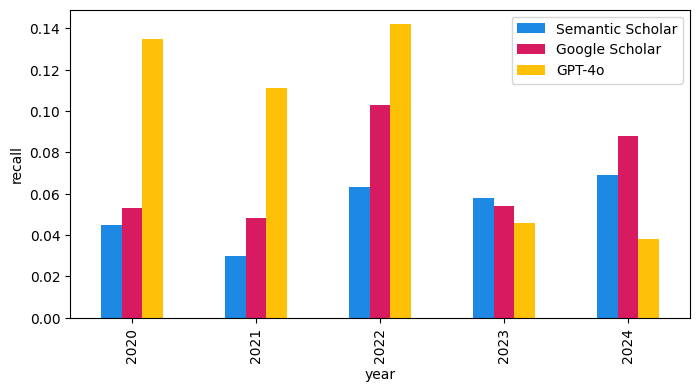

In [55]:
years = [2020, 2021, 2022, 2023, 2024]
data = defaultdict(list)
for i, method in enumerate(["Semantic Scholar", "Google Scholar", "GPT-4o"]):
    data["year"] = years
    for year in years:
        data[method].append(df_engines_years.loc[(year,"Mean")][(method, "recall")]/100)

df = pd.DataFrame(data)
df.plot.bar(x="year", y=["Semantic Scholar", "Google Scholar", "GPT-4o"], ylabel="recall", color=colormap, figsize=(8,4))